# Final Experiment (Pain Area Classification)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.model_selection import KFold
from sklearn.utils import compute_class_weight
from sklearn.metrics import balanced_accuracy_score
from tensorflow.keras.models import load_model
from pathlib import Path

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, load_fusioned_dataset, get_class_names
from src.lib.time_series_augmentation.utils.augmentation import jitter, rotation
from src.models.CNNLSTM import CNNLSTM
from src.models.CNNLSTMfusioned import CNNLSTM_fusioned
from src.models.RCNN import RCNN
from src.models.RCNNfusioned import RCNN_fusioned
from src.lib.DeepStack.deepstack.base import KerasMember
from src.lib.DeepStack.deepstack.ensemble import DirichletEnsemble

In [2]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
epochs = 100

cnnlstm_acc = []
rcnn_acc = []
cnnlstm_auc = []
rcnn_auc = []

In [3]:
model_path = Path(os.path.abspath('')).parent / 'models' / 'saved'

## 1. Unimodal Body (Skeleton Pose Estimation)

In [4]:
X_train, X_test, y_train, y_test = load_dataset('skeleton', nopain=False)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(380, 1, 350, 35) (380, 4)
(235, 1, 350, 35) (235, 4)


In [5]:
extra_X_train, extra_X_test, extra_y_train, extra_y_test = load_dataset('skeleton', nopain=False, only_minority=True)
jitter_X = jitter(extra_X_train, sigma=0.03)
reshaped_X = extra_X_train.reshape((extra_X_train.shape[0], extra_X_train.shape[2], extra_X_train.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))
augmented_X = np.concatenate((rotated_X, jitter_X), axis=0)
add_y = np.concatenate((extra_y_train, extra_y_train), axis=0)
full_X = np.concatenate((augmented_X, X), axis=0)
full_y = np.concatenate((add_y, y), axis=0)
full_X.shape

(656, 1, 350, 35)

In [6]:
classes = get_class_names('skeleton', nopain=False)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

Lower Body       245
Back Region       73
Upper Body        57
Head and Neck      5
dtype: int64

In [7]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 1.3013698630136987, 1: 19.0, 2: 0.3877551020408163, 3: 1.6666666666666667}

### 1.1 CNN + BiLSTM

Epoch 1/100
14/14 - 13s - loss: 1.8809 - accuracy: 0.3341 - auc: 0.5795 - precision: 0.1667 - recall: 0.0023 - f1_score: 0.1958 - val_loss: 1.4407 - val_accuracy: 0.2694 - val_auc: 0.5130 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.1937 - 13s/epoch - 961ms/step
Epoch 2/100
14/14 - 2s - loss: 1.5386 - accuracy: 0.3913 - auc: 0.6066 - precision: 0.4948 - recall: 0.1098 - f1_score: 0.3230 - val_loss: 1.4351 - val_accuracy: 0.2009 - val_auc: 0.4803 - val_precision: 1.0000 - val_recall: 0.0046 - val_f1_score: 0.1589 - 2s/epoch - 151ms/step
Epoch 3/100
14/14 - 2s - loss: 1.3099 - accuracy: 0.3684 - auc: 0.6503 - precision: 0.4824 - recall: 0.1876 - f1_score: 0.2885 - val_loss: 1.3134 - val_accuracy: 0.2694 - val_auc: 0.6312 - val_precision: 0.4348 - val_recall: 0.0913 - val_f1_score: 0.2237 - 2s/epoch - 155ms/step
Epoch 4/100
14/14 - 2s - loss: 1.1728 - accuracy: 0.4394 - auc: 0.7329 - precision: 0.5113 - recall: 0.3112 - f1_score: 0.3693 - val_loss: 1.2761 - val_a

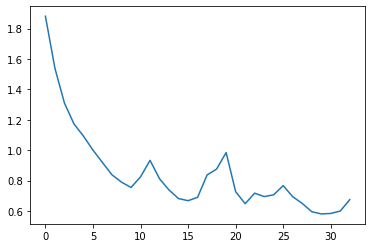

Epoch 1/100
14/14 - 9s - loss: 2.0156 - accuracy: 0.2197 - auc_1: 0.4537 - precision_1: 0.2727 - recall_1: 0.0137 - f1_score: 0.1916 - val_loss: 1.4166 - val_accuracy: 0.2831 - val_auc_1: 0.5082 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.2160 - 9s/epoch - 641ms/step
Epoch 2/100
14/14 - 2s - loss: 1.6590 - accuracy: 0.3204 - auc_1: 0.5754 - precision_1: 0.5208 - recall_1: 0.0572 - f1_score: 0.2569 - val_loss: 1.2977 - val_accuracy: 0.3059 - val_auc_1: 0.6216 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.1981 - 2s/epoch - 153ms/step
Epoch 3/100
14/14 - 2s - loss: 1.3872 - accuracy: 0.3936 - auc_1: 0.6808 - precision_1: 0.5342 - recall_1: 0.1785 - f1_score: 0.3394 - val_loss: 1.2586 - val_accuracy: 0.3014 - val_auc_1: 0.6482 - val_precision_1: 0.3000 - val_recall_1: 0.0137 - val_f1_score: 0.1828 - 2s/epoch - 152ms/step
Epoch 4/100
14/14 - 2s - loss: 1.1017 - accuracy: 0.4394 - auc_1: 0.7310 - precision_1: 0.5769 - recall_1: 0.30

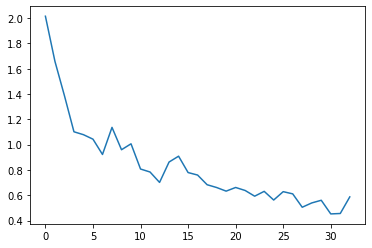

Epoch 1/100
14/14 - 9s - loss: 1.9433 - accuracy: 0.2511 - auc_2: 0.4703 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score: 0.2062 - val_loss: 1.4078 - val_accuracy: 0.2248 - val_auc_2: 0.4509 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.1581 - 9s/epoch - 643ms/step
Epoch 2/100
14/14 - 2s - loss: 1.5771 - accuracy: 0.3151 - auc_2: 0.5812 - precision_2: 0.3962 - recall_2: 0.0479 - f1_score: 0.2622 - val_loss: 1.3111 - val_accuracy: 0.2615 - val_auc_2: 0.6110 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.2089 - 2s/epoch - 149ms/step
Epoch 3/100
14/14 - 2s - loss: 1.2594 - accuracy: 0.4315 - auc_2: 0.6932 - precision_2: 0.5655 - recall_2: 0.2169 - f1_score: 0.3688 - val_loss: 1.2291 - val_accuracy: 0.2890 - val_auc_2: 0.6751 - val_precision_2: 0.2500 - val_recall_2: 0.0046 - val_f1_score: 0.2344 - 2s/epoch - 148ms/step
Epoch 4/100
14/14 - 2s - loss: 1.0679 - accuracy: 0.4635 - auc_2: 0.7414 - precision_2: 0.5466 - recall

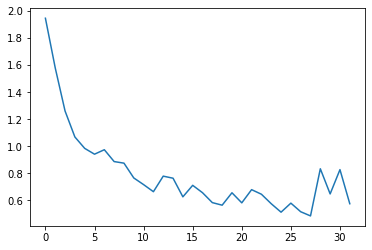

In [8]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    cnnlstm_area_body_model = CNNLSTM(n_features, n_length, n_outputs, multiclass=True)
    history = cnnlstm_area_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_area_body_model.save(model_path / 'body_area_cnnlstm.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Unimodal Body CNN-BiLSTM')

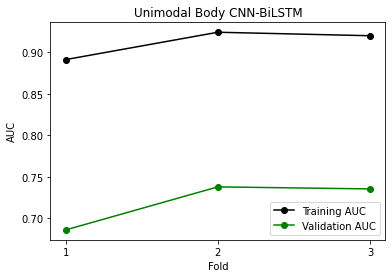

In [9]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Unimodal Body CNN-BiLSTM")

#### Training performance and variance

In [10]:
body_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_cnnlstm_train_results

{'Accuracy': 0.6814015110333761,
 'ROC/AUC': 0.9116943875948588,
 'Precision': 0.7229940096537272,
 'Recall': 0.6311191916465759,
 'F1-score': 0.6699351270993551}

In [11]:
body_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
body_cnnlstm_train_var

{'Accuracy': 0.0010698864157450633,
 'ROC/AUC': 0.0002139171026042972,
 'Precision': 0.0010709829915387873,
 'Recall': 0.001799083613188183,
 'F1-score': 0.0014665418370903972}

#### Validation performance and variance

In [12]:
body_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_cnnlstm_val_results

{'Accuracy': 0.46344239513079327,
 'ROC/AUC': 0.7199398676554362,
 'Precision': 0.483795831600825,
 'Recall': 0.41009313861529034,
 'F1-score': 0.39760372042655945}

In [13]:
body_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
body_cnnlstm_val_var

{'Accuracy': 0.00044726190082064774,
 'ROC/AUC': 0.000569142626271773,
 'Precision': 0.0006727390235783146,
 'Recall': 0.0006430753492418815,
 'F1-score': 0.0009960797047311825}

#### Predictions and performance on test set

In [14]:
cnnlstm_area_body_model = load_model(model_path / 'body_area_cnnlstm.h5')
y_pred = cnnlstm_area_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_area_body_model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cnnlstm_auc.append(round(auc, 2))
cnnlstm_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 2s 47ms/step - loss: 1.1825 - accuracy: 0.3404 - auc_1: 0.6700 - precision_1: 0.3333 - recall_1: 0.0085 - f1_score: 0.2275
Accuracy: 34.04% 
Balanced Accuracy: 23.75% 
ROC/AUC: 0.67 
Precision: 0.33 
Recall: 0.01 
F1 score: 0.23


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

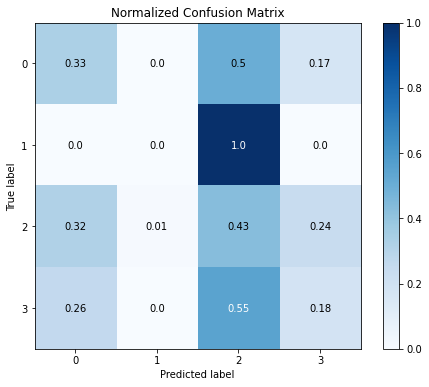

In [15]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

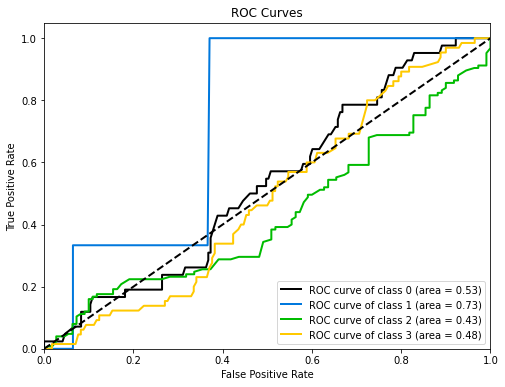

In [16]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

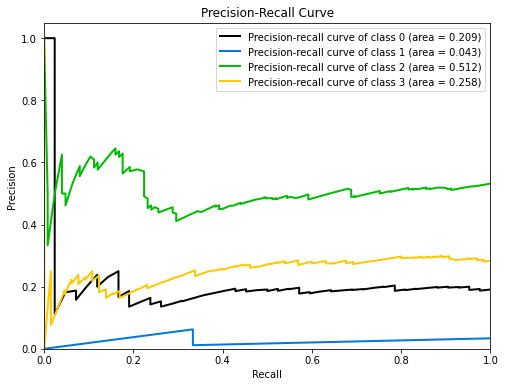

In [17]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, plot_micro=False, figsize=(8,6))

### 1.2 RCNN

Epoch 1/100
14/14 - 2s - loss: 3.5885 - accuracy: 0.2975 - auc_3: 0.5695 - precision_3: 0.3075 - recall_3: 0.2265 - f1_score: 0.2020 - val_loss: 1.4095 - val_accuracy: 0.2831 - val_auc_3: 0.6452 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.1103 - 2s/epoch - 176ms/step
Epoch 2/100
14/14 - 0s - loss: 1.8406 - accuracy: 0.2952 - auc_3: 0.5287 - precision_3: 0.2727 - recall_3: 0.0206 - f1_score: 0.2182 - val_loss: 1.5752 - val_accuracy: 0.2831 - val_auc_3: 0.5155 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.1103 - 417ms/epoch - 30ms/step
Epoch 3/100
14/14 - 0s - loss: 1.7687 - accuracy: 0.2654 - auc_3: 0.5066 - precision_3: 0.3125 - recall_3: 0.0229 - f1_score: 0.1958 - val_loss: 1.5419 - val_accuracy: 0.3105 - val_auc_3: 0.5178 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.1185 - 400ms/epoch - 29ms/step
Epoch 4/100
14/14 - 0s - loss: 1.6734 - accuracy: 0.3112 - auc_3: 0.5107 - precision_3: 0.3333 - re

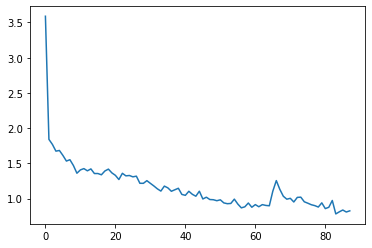

Epoch 1/100
14/14 - 2s - loss: 3.2924 - accuracy: 0.1831 - auc_4: 0.4021 - precision_4: 0.1134 - recall_4: 0.0503 - f1_score: 0.1532 - val_loss: 2.6500 - val_accuracy: 0.3105 - val_auc_4: 0.4954 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.1185 - 2s/epoch - 169ms/step
Epoch 2/100
14/14 - 0s - loss: 1.9848 - accuracy: 0.2494 - auc_4: 0.4539 - precision_4: 0.1484 - recall_4: 0.0435 - f1_score: 0.2125 - val_loss: 1.5337 - val_accuracy: 0.2603 - val_auc_4: 0.4948 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.1033 - 434ms/epoch - 31ms/step
Epoch 3/100
14/14 - 0s - loss: 1.7481 - accuracy: 0.2815 - auc_4: 0.5429 - precision_4: 0.2174 - recall_4: 0.0343 - f1_score: 0.2213 - val_loss: 1.4340 - val_accuracy: 0.2055 - val_auc_4: 0.4444 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.1448 - 436ms/epoch - 31ms/step
Epoch 4/100
14/14 - 0s - loss: 1.6236 - accuracy: 0.2838 - auc_4: 0.5635 - precision_4: 0.3077 - re

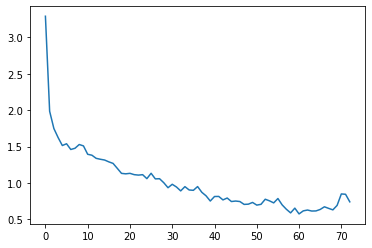

Epoch 1/100
14/14 - 3s - loss: 2.4099 - accuracy: 0.2397 - auc_5: 0.4982 - precision_5: 0.2950 - recall_5: 0.0936 - f1_score: 0.1869 - val_loss: 1.3524 - val_accuracy: 0.3716 - val_auc_5: 0.5795 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.1838 - 3s/epoch - 183ms/step
Epoch 2/100
14/14 - 0s - loss: 1.8468 - accuracy: 0.2420 - auc_5: 0.5063 - precision_5: 0.0417 - recall_5: 0.0023 - f1_score: 0.2040 - val_loss: 1.4582 - val_accuracy: 0.2523 - val_auc_5: 0.5517 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.1461 - 395ms/epoch - 28ms/step
Epoch 3/100
14/14 - 0s - loss: 1.7664 - accuracy: 0.2808 - auc_5: 0.5423 - precision_5: 0.3028 - recall_5: 0.0753 - f1_score: 0.2146 - val_loss: 1.6766 - val_accuracy: 0.2110 - val_auc_5: 0.4209 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.1592 - 416ms/epoch - 30ms/step
Epoch 4/100
14/14 - 0s - loss: 1.7603 - accuracy: 0.2146 - auc_5: 0.4903 - precision_5: 0.3077 - re

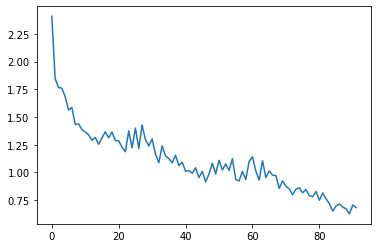

In [18]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    rcnn_area_body_model = RCNN(n_features, n_length, n_outputs, multiclass=True)
    history = rcnn_area_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_area_body_model.save(model_path / 'body_area_rcnn.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Unimodal Body RCNN')

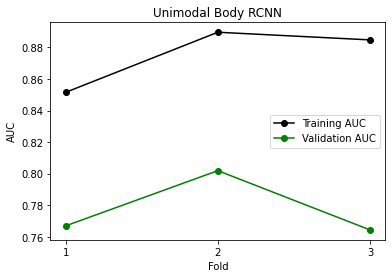

In [19]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Unimodal Body RCNN")

#### Training performance and variance

In [20]:
body_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_rcnn_train_results

{'Accuracy': 0.6371952891349792,
 'ROC/AUC': 0.8753302097320557,
 'Precision': 0.6920151313145956,
 'Recall': 0.5457004308700562,
 'F1-score': 0.6434943079948425}

In [21]:
body_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
body_rcnn_train_var

{'Accuracy': 0.0007339976443840138,
 'ROC/AUC': 0.0002864857164747529,
 'Precision': 0.00113494484014688,
 'Recall': 0.003112865275172775,
 'F1-score': 0.0009530534159149321}

#### Validation performance and variance

In [22]:
body_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_rcnn_val_results

{'Accuracy': 0.4832223157087962,
 'ROC/AUC': 0.7776955564816793,
 'Precision': 0.508017877737681,
 'Recall': 0.37200648585955304,
 'F1-score': 0.46270355582237244}

In [23]:
body_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
body_rcnn_val_var

{'Accuracy': 5.023650328992188e-05,
 'ROC/AUC': 0.00029356449356122814,
 'Precision': 0.0016450405528684166,
 'Recall': 0.001911537247842629,
 'F1-score': 0.0002685992151310046}

#### Predictions and performance on test set

In [24]:
rcnn_area_body_model = load_model(model_path / 'body_area_rcnn.h5')
y_pred = rcnn_area_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_area_body_model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
rcnn_auc.append(round(auc, 2))
rcnn_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 0s 8ms/step - loss: 1.4559 - accuracy: 0.3234 - auc_4: 0.6275 - precision_4: 0.3409 - recall_4: 0.2553 - f1_score: 0.2133
Accuracy: 32.34% 
Balanced Accuracy: 24.00% 
ROC/AUC: 0.63 
Precision: 0.34 
Recall: 0.26 
F1 score: 0.21


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

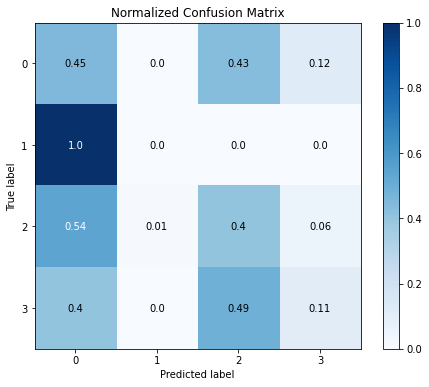

In [25]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

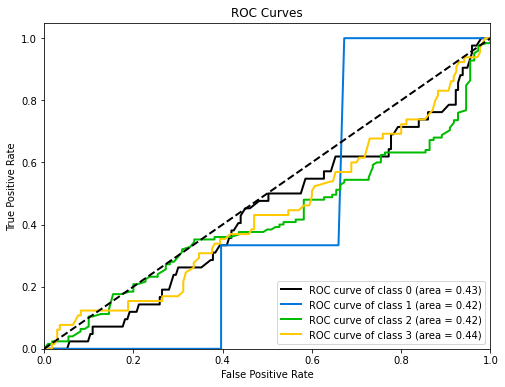

In [26]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

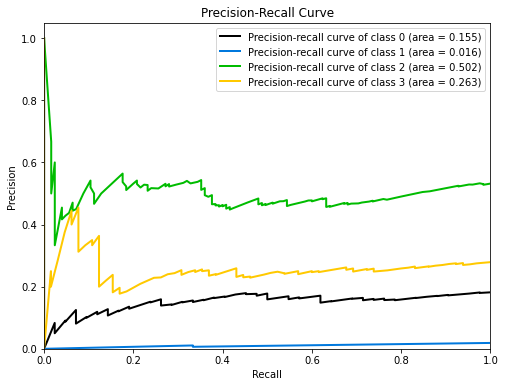

In [27]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, plot_micro=False, figsize=(8,6))

## 2. Unimodal Face (Facial Expression + Head Pose)

In [28]:
X_train, X_test, y_train, y_test = load_dataset('AUs', nopain=False)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(366, 1, 350, 25) (366, 4)
(231, 1, 350, 25) (231, 4)


In [29]:
extra_X_train, extra_X_test, extra_y_train, extra_y_test = load_dataset('AUs', nopain=False, only_minority=True)
jitter_X = jitter(extra_X_train, sigma=0.03)
reshaped_X = extra_X_train.reshape((extra_X_train.shape[0], extra_X_train.shape[2], extra_X_train.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))
augmented_X = np.concatenate((rotated_X, jitter_X), axis=0)
add_y = np.concatenate((extra_y_train, extra_y_train), axis=0)
full_X = np.concatenate((augmented_X, X), axis=0)
full_y = np.concatenate((add_y, y), axis=0)
full_X.shape

(632, 1, 350, 25)

In [30]:
classes = get_class_names('AUs', nopain=False)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

Lower Body       236
Back Region       69
Upper Body        57
Head and Neck      4
dtype: int64

In [31]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 1.326086956521739, 1: 22.875, 2: 0.3877118644067797, 3: 1.605263157894737}

### 2.1 CNN + BiLSTM

Epoch 1/100
14/14 - 9s - loss: 1.7800 - accuracy: 0.2779 - auc_6: 0.5111 - precision_6: 0.3182 - recall_6: 0.0166 - f1_score: 0.2020 - val_loss: 1.3752 - val_accuracy: 0.3081 - val_auc_6: 0.5636 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_f1_score: 0.1890 - 9s/epoch - 660ms/step
Epoch 2/100
14/14 - 2s - loss: 1.5938 - accuracy: 0.3349 - auc_6: 0.5993 - precision_6: 0.5806 - recall_6: 0.0855 - f1_score: 0.2256 - val_loss: 1.3605 - val_accuracy: 0.2891 - val_auc_6: 0.6022 - val_precision_6: 0.3846 - val_recall_6: 0.0237 - val_f1_score: 0.1121 - 2s/epoch - 163ms/step
Epoch 3/100
14/14 - 2s - loss: 1.4889 - accuracy: 0.3753 - auc_6: 0.6492 - precision_6: 0.5440 - recall_6: 0.1615 - f1_score: 0.2546 - val_loss: 1.2771 - val_accuracy: 0.3270 - val_auc_6: 0.6781 - val_precision_6: 0.6667 - val_recall_6: 0.0190 - val_f1_score: 0.2335 - 2s/epoch - 162ms/step
Epoch 4/100
14/14 - 2s - loss: 1.3096 - accuracy: 0.4133 - auc_6: 0.6921 - precision_6: 0.5169 - recall_6: 0.2185 - f1_

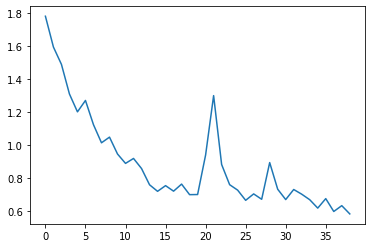

Epoch 1/100
14/14 - 9s - loss: 2.0534 - accuracy: 0.2352 - auc_7: 0.5192 - precision_7: 0.2105 - recall_7: 0.0095 - f1_score: 0.1739 - val_loss: 1.4416 - val_accuracy: 0.2844 - val_auc_7: 0.4935 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.1107 - 9s/epoch - 639ms/step
Epoch 2/100
14/14 - 2s - loss: 1.7873 - accuracy: 0.2328 - auc_7: 0.5253 - precision_7: 0.2500 - recall_7: 0.0570 - f1_score: 0.1894 - val_loss: 1.3415 - val_accuracy: 0.2938 - val_auc_7: 0.6018 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.1797 - 2s/epoch - 164ms/step
Epoch 3/100
14/14 - 2s - loss: 1.6399 - accuracy: 0.3112 - auc_7: 0.6080 - precision_7: 0.3396 - recall_7: 0.0855 - f1_score: 0.2488 - val_loss: 1.3298 - val_accuracy: 0.3033 - val_auc_7: 0.6062 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.1866 - 2s/epoch - 163ms/step
Epoch 4/100
14/14 - 2s - loss: 1.6557 - accuracy: 0.3444 - auc_7: 0.6459 - precision_7: 0.2981 - recall

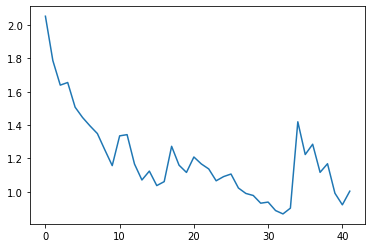

Epoch 1/100
14/14 - 9s - loss: 2.0741 - accuracy: 0.2038 - auc_8: 0.4528 - precision_8: 0.1000 - recall_8: 0.0024 - f1_score: 0.1714 - val_loss: 1.4321 - val_accuracy: 0.2952 - val_auc_8: 0.5060 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_f1_score: 0.1453 - 9s/epoch - 656ms/step
Epoch 2/100
14/14 - 2s - loss: 1.7651 - accuracy: 0.3128 - auc_8: 0.5952 - precision_8: 0.4219 - recall_8: 0.0640 - f1_score: 0.2515 - val_loss: 1.5597 - val_accuracy: 0.0095 - val_auc_8: 0.3848 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_f1_score: 0.0047 - 2s/epoch - 163ms/step
Epoch 3/100
14/14 - 2s - loss: 1.6818 - accuracy: 0.2180 - auc_8: 0.5205 - precision_8: 0.1720 - recall_8: 0.0640 - f1_score: 0.2196 - val_loss: 1.3126 - val_accuracy: 0.3286 - val_auc_8: 0.6323 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_f1_score: 0.2654 - 2s/epoch - 164ms/step
Epoch 4/100
14/14 - 2s - loss: 1.3825 - accuracy: 0.4171 - auc_8: 0.6926 - precision_8: 0.4518 - recall

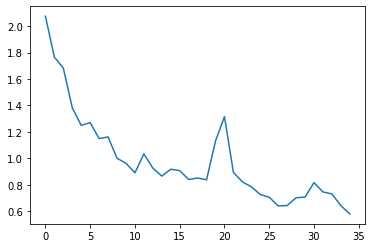

In [32]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    cnnlstm_area_face_model = CNNLSTM(n_features, n_length, n_outputs, multiclass=True)
    history = cnnlstm_area_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_area_face_model.save(model_path / 'face_area_cnnlstm.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Unimodal Face CNN-BiLSTM')

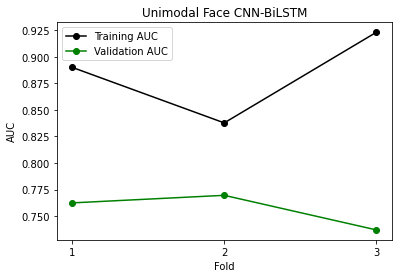

In [33]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Unimodal Face CNN-BiLSTM")

#### Training performance and variance

In [34]:
face_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_cnnlstm_train_results

{'Accuracy': 0.6510208447774252,
 'ROC/AUC': 0.8835888703664144,
 'Precision': 0.6890836159388224,
 'Recall': 0.6059108475844065,
 'F1-score': 0.6128876010576884}

In [35]:
face_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
face_cnnlstm_train_var

{'Accuracy': 0.006747982459021134,
 'ROC/AUC': 0.0012341592855173013,
 'Precision': 0.004120075987170285,
 'Recall': 0.010822759781871798,
 'F1-score': 0.008980606296173083}

#### Validation performance and variance

In [36]:
face_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_cnnlstm_val_results

{'Accuracy': 0.4841269850730896,
 'ROC/AUC': 0.7562979857126871,
 'Precision': 0.5077078441778818,
 'Recall': 0.4240728219350179,
 'F1-score': 0.4304375946521759}

In [37]:
face_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
face_cnnlstm_val_var

{'Accuracy': 0.0008071330245679557,
 'ROC/AUC': 0.0001953461972669225,
 'Precision': 0.001920638780879792,
 'Recall': 0.00011328829018846735,
 'F1-score': 0.0012483904318158305}

#### Predictions and performance on test set

In [38]:
cnnlstm_area_face_model = load_model(model_path / 'face_area_cnnlstm.h5')
y_pred = cnnlstm_area_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_area_face_model.evaluate(X_test, y_test)
cnnlstm_auc.append(round(auc, 2))
cnnlstm_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 2s 47ms/step - loss: 1.4493 - accuracy: 0.2814 - auc_7: 0.6146 - precision_7: 0.2927 - recall_7: 0.1558 - f1_score: 0.2127
Accuracy: 28.14% 
ROC/AUC: 0.61 
Precision: 0.29 
Recall: 0.16 
F1 score: 0.21


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

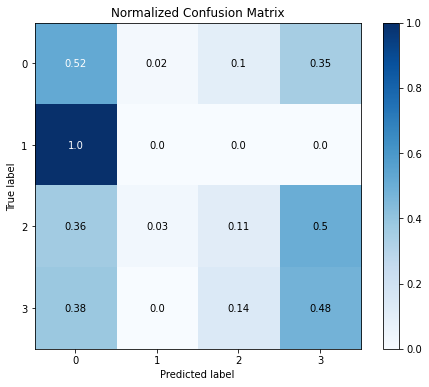

In [39]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

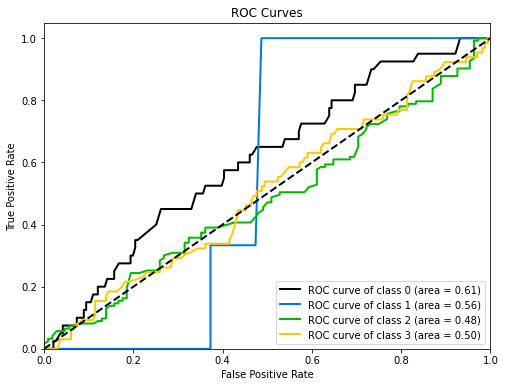

In [40]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

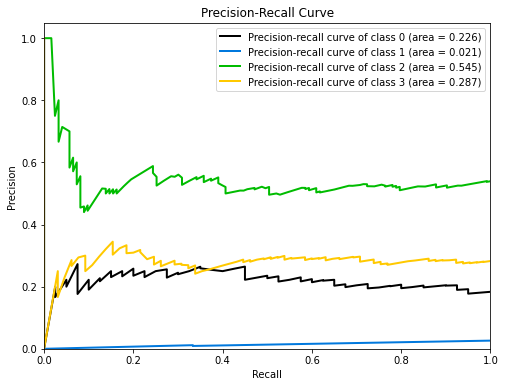

In [41]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, figsize=(8,6), plot_micro=False)

### 2.2 RCNN

Epoch 1/100
14/14 - 3s - loss: 2.4781 - accuracy: 0.2589 - auc_9: 0.4695 - precision_9: 0.2684 - recall_9: 0.1473 - f1_score: 0.1923 - val_loss: 1.7159 - val_accuracy: 0.2891 - val_auc_9: 0.5494 - val_precision_9: 0.3087 - val_recall_9: 0.2180 - val_f1_score: 0.1121 - 3s/epoch - 199ms/step
Epoch 2/100
14/14 - 0s - loss: 1.6795 - accuracy: 0.2779 - auc_9: 0.5621 - precision_9: 0.3235 - recall_9: 0.1045 - f1_score: 0.1876 - val_loss: 1.5623 - val_accuracy: 0.1469 - val_auc_9: 0.4374 - val_precision_9: 0.1111 - val_recall_9: 0.0047 - val_f1_score: 0.1166 - 439ms/epoch - 31ms/step
Epoch 3/100
14/14 - 0s - loss: 1.7661 - accuracy: 0.2185 - auc_9: 0.5143 - precision_9: 0.2766 - recall_9: 0.0618 - f1_score: 0.1726 - val_loss: 1.3235 - val_accuracy: 0.3318 - val_auc_9: 0.5996 - val_precision_9: 0.5600 - val_recall_9: 0.0664 - val_f1_score: 0.1246 - 425ms/epoch - 30ms/step
Epoch 4/100
14/14 - 0s - loss: 1.6298 - accuracy: 0.3135 - auc_9: 0.6289 - precision_9: 0.4156 - recall_9: 0.0760 - f1_scor

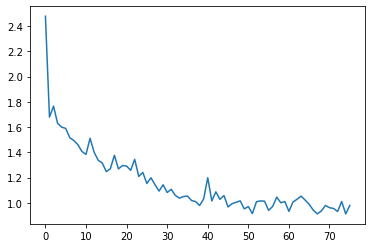

Epoch 1/100
14/14 - 2s - loss: 3.8376 - accuracy: 0.1211 - auc_10: 0.3618 - precision_10: 0.0871 - recall_10: 0.0546 - f1_score: 0.1136 - val_loss: 2.3472 - val_accuracy: 0.2749 - val_auc_10: 0.4806 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00 - val_f1_score: 0.1501 - 2s/epoch - 172ms/step
Epoch 2/100
14/14 - 0s - loss: 2.1031 - accuracy: 0.2494 - auc_10: 0.4905 - precision_10: 0.3778 - recall_10: 0.0808 - f1_score: 0.1734 - val_loss: 1.5531 - val_accuracy: 0.0995 - val_auc_10: 0.3558 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00 - val_f1_score: 0.1031 - 452ms/epoch - 32ms/step
Epoch 3/100
14/14 - 0s - loss: 1.9889 - accuracy: 0.2613 - auc_10: 0.4696 - precision_10: 0.3636 - recall_10: 0.0190 - f1_score: 0.2104 - val_loss: 1.5162 - val_accuracy: 0.2844 - val_auc_10: 0.4886 - val_precision_10: 1.0000 - val_recall_10: 0.0047 - val_f1_score: 0.1107 - 444ms/epoch - 32ms/step
Epoch 4/100
14/14 - 0s - loss: 1.9274 - accuracy: 0.2423 - auc_10: 0.4786 - precision_10:

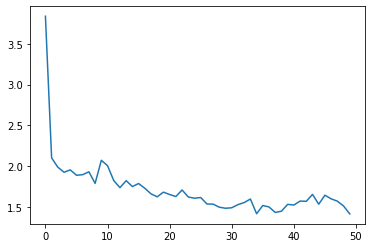

Epoch 1/100
14/14 - 2s - loss: 2.7863 - accuracy: 0.2370 - auc_11: 0.4613 - precision_11: 0.2556 - recall_11: 0.1611 - f1_score: 0.2061 - val_loss: 2.5982 - val_accuracy: 0.1190 - val_auc_11: 0.3615 - val_precision_11: 0.4444 - val_recall_11: 0.0952 - val_f1_score: 0.1231 - 2s/epoch - 170ms/step
Epoch 2/100
14/14 - 0s - loss: 1.9833 - accuracy: 0.2417 - auc_11: 0.4642 - precision_11: 0.3860 - recall_11: 0.1043 - f1_score: 0.2005 - val_loss: 1.7238 - val_accuracy: 0.1190 - val_auc_11: 0.3775 - val_precision_11: 0.4643 - val_recall_11: 0.0619 - val_f1_score: 0.1231 - 439ms/epoch - 31ms/step
Epoch 3/100
14/14 - 0s - loss: 1.8587 - accuracy: 0.2796 - auc_11: 0.4953 - precision_11: 0.3768 - recall_11: 0.0616 - f1_score: 0.2300 - val_loss: 1.4915 - val_accuracy: 0.2524 - val_auc_11: 0.5463 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00 - val_f1_score: 0.1653 - 421ms/epoch - 30ms/step
Epoch 4/100
14/14 - 0s - loss: 1.8147 - accuracy: 0.2844 - auc_11: 0.5324 - precision_11: 0.3043 

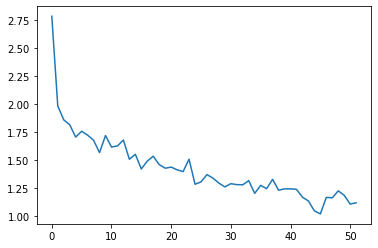

In [42]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    rcnn_area_face_model = RCNN(n_features, n_length, n_outputs, multiclass=True)
    history = rcnn_area_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_area_face_model.save(model_path / 'face_area_rcnn.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Unimodal Face RCNN')

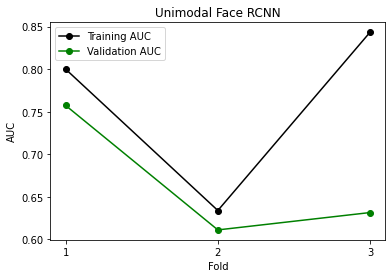

In [43]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Unimodal Face RCNN")

#### Training performance and variance

In [44]:
face_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_rcnn_train_results

{'Accuracy': 0.4817049602667491,
 'ROC/AUC': 0.7591472069422404,
 'Precision': 0.526594360669454,
 'Recall': 0.31475873788197833,
 'F1-score': 0.45907501379648846}

In [45]:
face_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
face_rcnn_train_var

{'Accuracy': 0.010061523398012855,
 'ROC/AUC': 0.00813958340539342,
 'Precision': 0.012468214274757687,
 'Recall': 0.02230186703380493,
 'F1-score': 0.013654481115152195}

#### Validation performance and variance

In [46]:
face_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_rcnn_val_results

{'Accuracy': 0.3733167846997579,
 'ROC/AUC': 0.6667571465174357,
 'Precision': 0.38491793473561603,
 'Recall': 0.2183705742160479,
 'F1-score': 0.32411467532316846}

In [47]:
face_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
face_rcnn_val_var

{'Accuracy': 0.009615462350046598,
 'ROC/AUC': 0.004176622848645037,
 'Precision': 0.01178764243779145,
 'Recall': 0.010174592753664884,
 'F1-score': 0.010451401937883978}

#### Predictions and performance on test set

In [48]:
rcnn_area_face_model = load_model(model_path / 'face_area_rcnn.h5')
y_pred = rcnn_area_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_area_face_model.evaluate(X_test, y_test)
rcnn_auc.append(round(auc, 2))
rcnn_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 0s 8ms/step - loss: 1.3786 - accuracy: 0.2857 - auc_9: 0.6362 - precision_9: 0.2992 - recall_9: 0.1645 - f1_score: 0.2173
Accuracy: 28.57% 
ROC/AUC: 0.64 
Precision: 0.30 
Recall: 0.16 
F1 score: 0.22


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

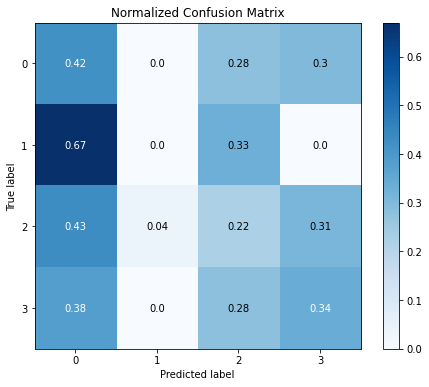

In [49]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

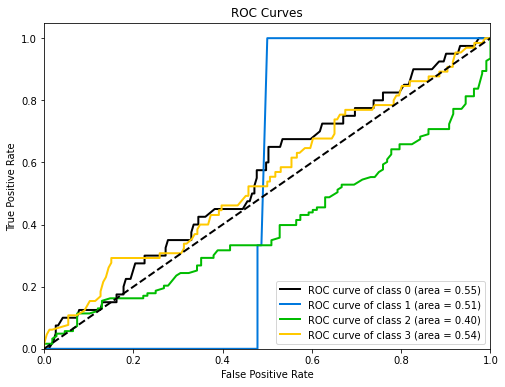

In [50]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

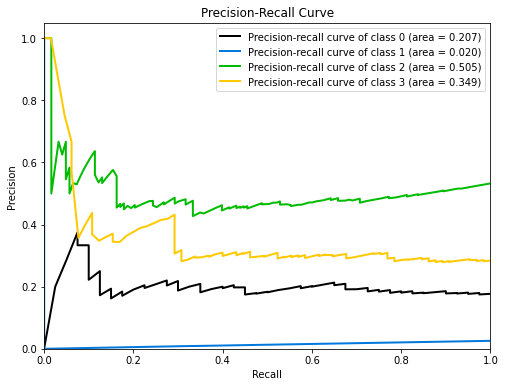

In [51]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, figsize=(8,6), plot_micro=False)

## 3. Multimodal Early Fusion

In [52]:
X_train, X_test, y_train, y_test = load_fusioned_dataset(nopain=False)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(366, 1, 350, 60) (366, 4)
(231, 1, 350, 60) (231, 4)


In [53]:
extra_X_train, extra_X_test, extra_y_train, extra_y_test = load_fusioned_dataset(nopain=False, only_minority=True)
jitter_X = jitter(extra_X_train, sigma=0.03)
reshaped_X = extra_X_train.reshape((extra_X_train.shape[0], extra_X_train.shape[2], extra_X_train.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))
augmented_X = np.concatenate((rotated_X, jitter_X), axis=0)
add_y = np.concatenate((extra_y_train, extra_y_train), axis=0)
full_X = np.concatenate((augmented_X, X), axis=0)
full_y = np.concatenate((add_y, y), axis=0)
full_X.shape

(632, 1, 350, 60)

### 3.1 CNN + BiLSTM

Epoch 1/100
14/14 - 9s - loss: 1.7349 - accuracy: 0.3112 - auc_12: 0.6268 - precision_12: 0.5714 - recall_12: 0.0285 - f1_score: 0.2077 - val_loss: 1.3394 - val_accuracy: 0.2796 - val_auc_12: 0.6064 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00 - val_f1_score: 0.1422 - 9s/epoch - 661ms/step
Epoch 2/100
14/14 - 2s - loss: 1.3764 - accuracy: 0.3943 - auc_12: 0.6591 - precision_12: 0.5851 - recall_12: 0.1306 - f1_score: 0.3160 - val_loss: 1.2712 - val_accuracy: 0.3412 - val_auc_12: 0.6683 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00 - val_f1_score: 0.2089 - 2s/epoch - 165ms/step
Epoch 3/100
14/14 - 2s - loss: 1.1760 - accuracy: 0.4703 - auc_12: 0.7360 - precision_12: 0.6346 - recall_12: 0.2352 - f1_score: 0.3907 - val_loss: 1.2441 - val_accuracy: 0.2986 - val_auc_12: 0.6906 - val_precision_12: 0.4483 - val_recall_12: 0.0616 - val_f1_score: 0.2385 - 2s/epoch - 162ms/step
Epoch 4/100
14/14 - 2s - loss: 1.0601 - accuracy: 0.4822 - auc_12: 0.7567 - precision_12: 0.5

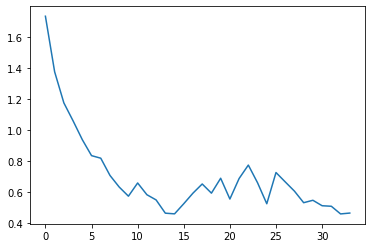

Epoch 1/100
14/14 - 9s - loss: 2.0939 - accuracy: 0.2542 - auc_13: 0.5248 - precision_13: 1.0000 - recall_13: 0.0048 - f1_score: 0.1863 - val_loss: 1.5430 - val_accuracy: 0.0664 - val_auc_13: 0.3275 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00 - val_f1_score: 0.0663 - 9s/epoch - 632ms/step
Epoch 2/100
14/14 - 2s - loss: 1.6751 - accuracy: 0.2518 - auc_13: 0.5044 - precision_13: 0.5000 - recall_13: 0.0190 - f1_score: 0.2035 - val_loss: 1.4761 - val_accuracy: 0.2559 - val_auc_13: 0.4288 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00 - val_f1_score: 0.1437 - 2s/epoch - 163ms/step
Epoch 3/100
14/14 - 2s - loss: 1.4502 - accuracy: 0.3777 - auc_13: 0.6445 - precision_13: 0.5522 - recall_13: 0.0879 - f1_score: 0.2965 - val_loss: 1.3349 - val_accuracy: 0.2749 - val_auc_13: 0.6146 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00 - val_f1_score: 0.2247 - 2s/epoch - 163ms/step
Epoch 4/100
14/14 - 2s - loss: 1.2168 - accuracy: 0.4086 - auc_13: 0.7227 - precision

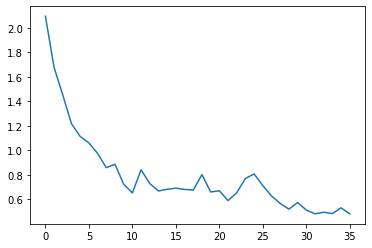

Epoch 1/100
14/14 - 9s - loss: 2.0426 - accuracy: 0.2701 - auc_14: 0.5390 - precision_14: 0.6154 - recall_14: 0.0190 - f1_score: 0.2118 - val_loss: 1.5399 - val_accuracy: 0.0571 - val_auc_14: 0.3611 - val_precision_14: 0.0000e+00 - val_recall_14: 0.0000e+00 - val_f1_score: 0.0693 - 9s/epoch - 647ms/step
Epoch 2/100
14/14 - 2s - loss: 1.6113 - accuracy: 0.2512 - auc_14: 0.5197 - precision_14: 0.3793 - recall_14: 0.0782 - f1_score: 0.2356 - val_loss: 1.3465 - val_accuracy: 0.2476 - val_auc_14: 0.5646 - val_precision_14: 0.0000e+00 - val_recall_14: 0.0000e+00 - val_f1_score: 0.1655 - 2s/epoch - 162ms/step
Epoch 3/100
14/14 - 2s - loss: 1.4193 - accuracy: 0.4242 - auc_14: 0.6874 - precision_14: 0.4957 - recall_14: 0.1374 - f1_score: 0.3785 - val_loss: 1.2842 - val_accuracy: 0.3667 - val_auc_14: 0.6489 - val_precision_14: 0.4615 - val_recall_14: 0.0286 - val_f1_score: 0.2166 - 2s/epoch - 161ms/step
Epoch 4/100
14/14 - 2s - loss: 1.1413 - accuracy: 0.4479 - auc_14: 0.7167 - precision_14: 0.5

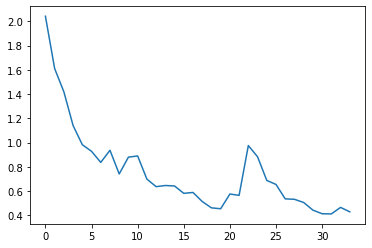

In [54]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    cnnlstm_area_earlyfusion_model = CNNLSTM(n_features, n_length, n_outputs, multiclass=True)
    history = cnnlstm_area_earlyfusion_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_area_earlyfusion_model.save(model_path / 'early_area_cnnlstm.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Early Fusion CNN-BiLSTM')

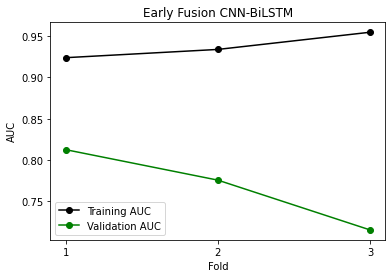

In [55]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Early Fusion CNN-BiLSTM")

#### Training performance and variance

In [56]:
early_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_cnnlstm_train_results

{'Accuracy': 0.7547083894411722,
 'ROC/AUC': 0.9372356534004211,
 'Precision': 0.7680091659228007,
 'Recall': 0.7246362964312235,
 'F1-score': 0.7225736975669861}

In [57]:
early_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
early_cnnlstm_train_var

{'Accuracy': 0.0013403422376738504,
 'ROC/AUC': 0.0001638691230022952,
 'Precision': 0.0013923135694974397,
 'Recall': 0.0019423877047357347,
 'F1-score': 0.0017321576800171101}

#### Validation performance and variance

In [58]:
early_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_cnnlstm_val_results

{'Accuracy': 0.48092229167620343,
 'ROC/AUC': 0.7679980595906576,
 'Precision': 0.4858044485251109,
 'Recall': 0.45558563868204754,
 'F1-score': 0.4565481940905253}

In [59]:
early_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
early_cnnlstm_val_var

{'Accuracy': 0.003611273693328304,
 'ROC/AUC': 0.0015963383889317443,
 'Precision': 0.004929195860414341,
 'Recall': 0.0040919082021615176,
 'F1-score': 0.005201862545261646}

#### Predictions and performance on test set

In [60]:
cnnlstm_area_earlyfusion_model = load_model(model_path / 'early_area_cnnlstm.h5')
y_pred = cnnlstm_area_earlyfusion_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_area_earlyfusion_model.evaluate(X_test, y_test)
cnnlstm_auc.append(round(auc, 2))
cnnlstm_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 2s 46ms/step - loss: 1.3995 - accuracy: 0.2727 - auc_12: 0.6174 - precision_12: 0.2589 - recall_12: 0.1255 - f1_score: 0.1900
Accuracy: 27.27% 
ROC/AUC: 0.62 
Precision: 0.26 
Recall: 0.13 
F1 score: 0.19


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

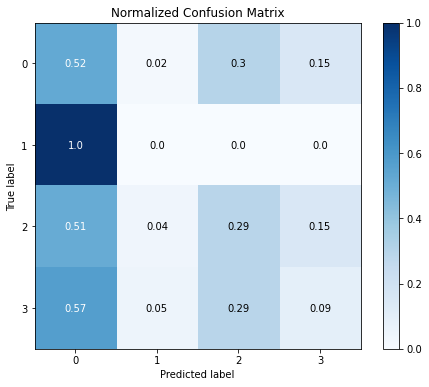

In [61]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

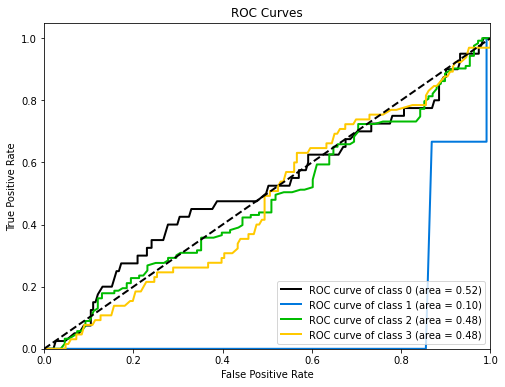

In [62]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

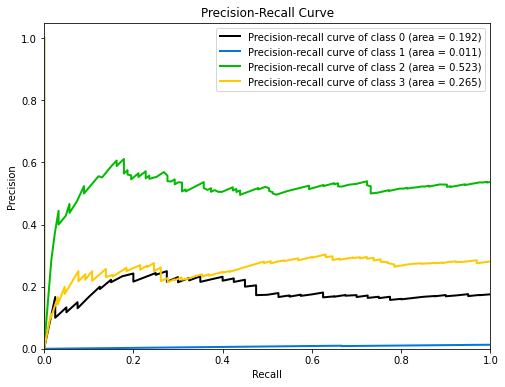

In [63]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, figsize=(8,6), plot_micro=False)

### 3.2 RCNN

Epoch 1/100
14/14 - 2s - loss: 3.0866 - accuracy: 0.3444 - auc_15: 0.6106 - precision_15: 0.3266 - recall_15: 0.2684 - f1_score: 0.2327 - val_loss: 1.3539 - val_accuracy: 0.2891 - val_auc_15: 0.6402 - val_precision_15: 0.3778 - val_recall_15: 0.0806 - val_f1_score: 0.1121 - 2s/epoch - 171ms/step
Epoch 2/100
14/14 - 0s - loss: 1.8653 - accuracy: 0.3373 - auc_15: 0.6308 - precision_15: 0.3383 - recall_15: 0.1069 - f1_score: 0.2176 - val_loss: 1.4583 - val_accuracy: 0.3223 - val_auc_15: 0.4835 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00 - val_f1_score: 0.1560 - 426ms/epoch - 30ms/step
Epoch 3/100
14/14 - 0s - loss: 1.7404 - accuracy: 0.2827 - auc_15: 0.4787 - precision_15: 0.4286 - recall_15: 0.0214 - f1_score: 0.2139 - val_loss: 1.4045 - val_accuracy: 0.3033 - val_auc_15: 0.5486 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00 - val_f1_score: 0.1446 - 404ms/epoch - 29ms/step
Epoch 4/100
14/14 - 0s - loss: 1.6362 - accuracy: 0.3539 - auc_15: 0.5904 - precision_15:

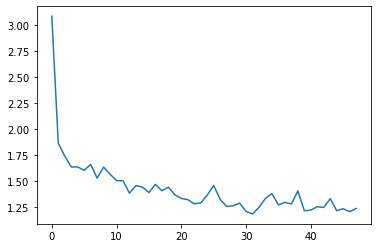

Epoch 1/100
14/14 - 2s - loss: 3.0417 - accuracy: 0.1948 - auc_16: 0.4283 - precision_16: 0.1694 - recall_16: 0.0736 - f1_score: 0.1574 - val_loss: 1.6469 - val_accuracy: 0.2844 - val_auc_16: 0.5000 - val_precision_16: 0.7500 - val_recall_16: 0.0142 - val_f1_score: 0.1107 - 2s/epoch - 173ms/step
Epoch 2/100
14/14 - 0s - loss: 1.9846 - accuracy: 0.2328 - auc_16: 0.4718 - precision_16: 0.2000 - recall_16: 0.0190 - f1_score: 0.1875 - val_loss: 1.4742 - val_accuracy: 0.2844 - val_auc_16: 0.5097 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00 - val_f1_score: 0.1107 - 460ms/epoch - 33ms/step
Epoch 3/100
14/14 - 0s - loss: 1.9189 - accuracy: 0.2945 - auc_16: 0.5433 - precision_16: 0.4146 - recall_16: 0.0404 - f1_score: 0.2166 - val_loss: 2.2178 - val_accuracy: 0.0142 - val_auc_16: 0.3154 - val_precision_16: 0.0155 - val_recall_16: 0.0142 - val_f1_score: 0.0070 - 399ms/epoch - 28ms/step
Epoch 4/100
14/14 - 0s - loss: 1.8986 - accuracy: 0.1591 - auc_16: 0.4187 - precision_16: 0.0625 

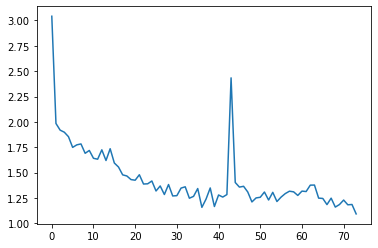

Epoch 1/100
14/14 - 2s - loss: 4.9029 - accuracy: 0.2725 - auc_17: 0.5316 - precision_17: 0.2750 - recall_17: 0.2346 - f1_score: 0.1863 - val_loss: 2.3388 - val_accuracy: 0.3667 - val_auc_17: 0.5441 - val_precision_17: 0.3667 - val_recall_17: 0.3667 - val_f1_score: 0.1341 - 2s/epoch - 171ms/step
Epoch 2/100
14/14 - 0s - loss: 2.3256 - accuracy: 0.2038 - auc_17: 0.4262 - precision_17: 0.1947 - recall_17: 0.0521 - f1_score: 0.1755 - val_loss: 1.6141 - val_accuracy: 0.2619 - val_auc_17: 0.4825 - val_precision_17: 0.0000e+00 - val_recall_17: 0.0000e+00 - val_f1_score: 0.1471 - 448ms/epoch - 32ms/step
Epoch 3/100
14/14 - 0s - loss: 1.9828 - accuracy: 0.2583 - auc_17: 0.4797 - precision_17: 0.4167 - recall_17: 0.0237 - f1_score: 0.1958 - val_loss: 1.6067 - val_accuracy: 0.0095 - val_auc_17: 0.3660 - val_precision_17: 0.0000e+00 - val_recall_17: 0.0000e+00 - val_f1_score: 0.0048 - 440ms/epoch - 31ms/step
Epoch 4/100
14/14 - 0s - loss: 1.8608 - accuracy: 0.1517 - auc_17: 0.4172 - precision_17:

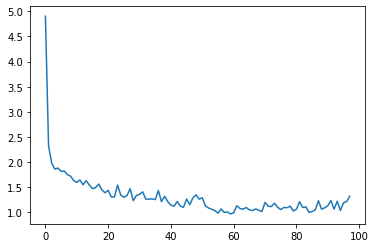

In [64]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_X):
    X_train, X_val = full_X[train_index], full_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    rcnn_area_earlyfusion_model = RCNN(n_features, n_length, n_outputs, multiclass=True)
    history = rcnn_area_earlyfusion_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_area_earlyfusion_model.save(model_path / 'early_area_rcnn.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Early Fusion RCNN')

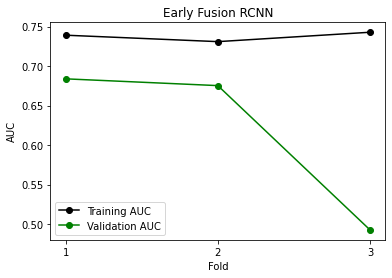

In [65]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Early Fusion RCNN")

#### Training performance and variance

In [66]:
early_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_rcnn_train_results

{'Accuracy': 0.4398445685704549,
 'ROC/AUC': 0.7376893162727356,
 'Precision': 0.5318476061026255,
 'Recall': 0.26734472811222076,
 'F1-score': 0.4212581515312195}

In [67]:
early_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
early_rcnn_train_var

{'Accuracy': 0.0006881284012971475,
 'ROC/AUC': 2.4649722782044137e-05,
 'Precision': 0.0008421716886438051,
 'Recall': 0.003322266391385368,
 'F1-score': 0.00014816470096394122}

#### Validation performance and variance

In [68]:
early_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_rcnn_val_results

{'Accuracy': 0.3052508880694707,
 'ROC/AUC': 0.6172394752502441,
 'Precision': 0.3697483042875926,
 'Recall': 0.20720680058002472,
 'F1-score': 0.2927803297837575}

In [69]:
early_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
early_rcnn_val_var

{'Accuracy': 0.0034511157927660367,
 'ROC/AUC': 0.007787751450202052,
 'Precision': 0.004778360032668121,
 'Recall': 0.0023775591685484265,
 'F1-score': 0.0061430417473788725}

#### Predictions and performance on test set

In [70]:
rcnn_area_earlyfusion_model = load_model(model_path / 'early_area_rcnn.h5')
y_pred = rcnn_area_earlyfusion_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_area_earlyfusion_model.evaluate(X_test, y_test)
rcnn_auc.append(round(auc, 2))
rcnn_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 0s 10ms/step - loss: 1.4077 - accuracy: 0.1688 - auc_15: 0.6012 - precision_15: 0.2000 - recall_15: 0.0693 - f1_score: 0.0739
Accuracy: 16.88% 
ROC/AUC: 0.60 
Precision: 0.20 
Recall: 0.07 
F1 score: 0.07


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

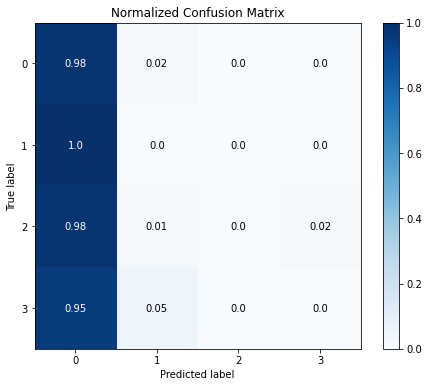

In [71]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

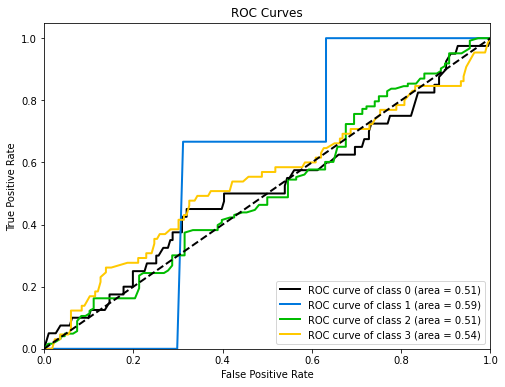

In [72]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

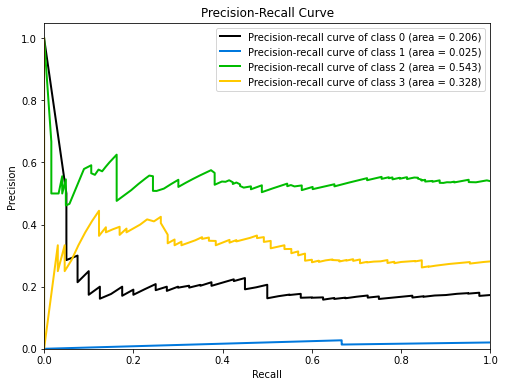

In [73]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, figsize=(8,6), plot_micro=False)

## 4. Multimodal Late Fusion

In [74]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', fusion=True, nopain=False)
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

(366, 1, 350, 35) (366, 4)
(231, 1, 350, 35) (231, 4)


In [75]:
extra_body_X_train, extra_body_X_test, extra_body_y_train, extra_body_y_test = load_dataset('skeleton', nopain=False, only_minority=True, fusion=True)
jitter_X = jitter(extra_body_X_train, sigma=0.03)
reshaped_X = extra_body_X_train.reshape((extra_body_X_train.shape[0], extra_body_X_train.shape[2], extra_body_X_train.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))
augmented_X = np.concatenate((rotated_X, jitter_X), axis=0)
add_y = np.concatenate((extra_body_y_train, extra_body_y_train), axis=0)
full_body_X = np.concatenate((augmented_X, body_X), axis=0)
full_y = np.concatenate((add_y, body_y), axis=0)
full_body_X.shape

(632, 1, 350, 35)

In [76]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs', nopain=False)
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

(366, 1, 350, 25) (366, 4)
(231, 1, 350, 25) (231, 4)


In [77]:
extra_face_X_train, extra_face_X_test, extra_face_y_train, extra_face_y_test = load_dataset('AUs', nopain=False, only_minority=True)
jitter_X = jitter(extra_face_X_train, sigma=0.03)
reshaped_X = extra_face_X_train.reshape((extra_face_X_train.shape[0], extra_face_X_train.shape[2], extra_face_X_train.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))
augmented_X = np.concatenate((rotated_X, jitter_X), axis=0)
add_y = np.concatenate((extra_face_y_train, extra_face_y_train), axis=0)
full_face_X = np.concatenate((augmented_X, face_X), axis=0)
full_face_X.shape

(632, 1, 350, 25)

In [78]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[2], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

### 4.1 CNN + BiLSTM (Concatenation)

Epoch 1/100
14/14 - 17s - loss: 1.8344 - accuracy: 0.2874 - auc_18: 0.5814 - precision_18: 0.3158 - recall_18: 0.0428 - f1_score: 0.1904 - val_loss: 1.3494 - val_accuracy: 0.3270 - val_auc_18: 0.5973 - val_precision_18: 0.0000e+00 - val_recall_18: 0.0000e+00 - val_f1_score: 0.2534 - 17s/epoch - 1s/step
Epoch 2/100
14/14 - 4s - loss: 1.4341 - accuracy: 0.3848 - auc_18: 0.6489 - precision_18: 0.5870 - recall_18: 0.1283 - f1_score: 0.2778 - val_loss: 1.2870 - val_accuracy: 0.3649 - val_auc_18: 0.7139 - val_precision_18: 0.0000e+00 - val_recall_18: 0.0000e+00 - val_f1_score: 0.3784 - 4s/epoch - 308ms/step
Epoch 3/100
14/14 - 4s - loss: 1.1569 - accuracy: 0.4276 - auc_18: 0.7304 - precision_18: 0.5767 - recall_18: 0.2233 - f1_score: 0.3474 - val_loss: 1.2402 - val_accuracy: 0.3697 - val_auc_18: 0.6981 - val_precision_18: 0.5000 - val_recall_18: 0.0095 - val_f1_score: 0.3170 - 4s/epoch - 301ms/step
Epoch 4/100
14/14 - 4s - loss: 1.0212 - accuracy: 0.4751 - auc_18: 0.7583 - precision_18: 0.56

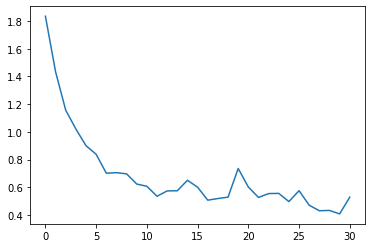

Epoch 1/100
14/14 - 17s - loss: 2.2030 - accuracy: 0.2660 - auc_19: 0.5290 - precision_19: 0.0000e+00 - recall_19: 0.0000e+00 - f1_score: 0.1870 - val_loss: 1.4928 - val_accuracy: 0.2749 - val_auc_19: 0.4902 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00 - val_f1_score: 0.1090 - 17s/epoch - 1s/step
Epoch 2/100
14/14 - 4s - loss: 1.6696 - accuracy: 0.2708 - auc_19: 0.5369 - precision_19: 0.4800 - recall_19: 0.0570 - f1_score: 0.2161 - val_loss: 1.4088 - val_accuracy: 0.3128 - val_auc_19: 0.6083 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00 - val_f1_score: 0.1675 - 4s/epoch - 295ms/step
Epoch 3/100
14/14 - 4s - loss: 1.3769 - accuracy: 0.3990 - auc_19: 0.6849 - precision_19: 0.5695 - recall_19: 0.2043 - f1_score: 0.3239 - val_loss: 1.4255 - val_accuracy: 0.2133 - val_auc_19: 0.5705 - val_precision_19: 0.2581 - val_recall_19: 0.0758 - val_f1_score: 0.0953 - 4s/epoch - 307ms/step
Epoch 4/100
14/14 - 4s - loss: 1.2728 - accuracy: 0.3729 - auc_19: 0.6905 - precision_

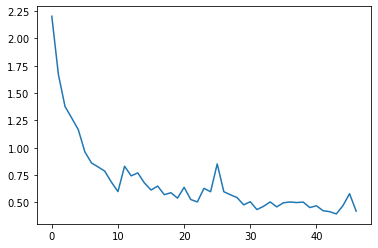

Epoch 1/100
14/14 - 17s - loss: 2.1064 - accuracy: 0.2749 - auc_20: 0.5326 - precision_20: 0.3571 - recall_20: 0.0118 - f1_score: 0.2093 - val_loss: 1.5754 - val_accuracy: 0.0095 - val_auc_20: 0.3471 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.0047 - 17s/epoch - 1s/step
Epoch 2/100
14/14 - 5s - loss: 1.5161 - accuracy: 0.3318 - auc_20: 0.5986 - precision_20: 0.4730 - recall_20: 0.0829 - f1_score: 0.2899 - val_loss: 1.4350 - val_accuracy: 0.2524 - val_auc_20: 0.4883 - val_precision_20: 0.0833 - val_recall_20: 0.0048 - val_f1_score: 0.1938 - 5s/epoch - 326ms/step
Epoch 3/100
14/14 - 5s - loss: 1.2405 - accuracy: 0.3863 - auc_20: 0.6925 - precision_20: 0.5196 - recall_20: 0.2204 - f1_score: 0.3346 - val_loss: 1.2266 - val_accuracy: 0.3714 - val_auc_20: 0.6920 - val_precision_20: 0.6154 - val_recall_20: 0.0381 - val_f1_score: 0.2956 - 5s/epoch - 335ms/step
Epoch 4/100
14/14 - 4s - loss: 1.0118 - accuracy: 0.5450 - auc_20: 0.8160 - precision_20: 0.6640 - rec

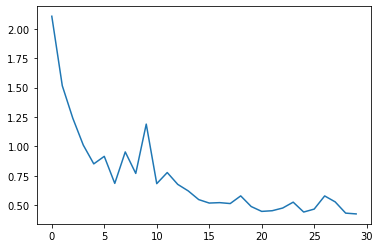

In [79]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_body_X):
    body_X_train, body_X_val = full_body_X[train_index], full_body_X[val_index]
    face_X_train, face_X_val = full_face_X[train_index], full_face_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    cnnlstm_area_latefusion_model = CNNLSTM_fusioned(body_features, face_features, n_length, n_outputs, multiclass=True)
    history = cnnlstm_area_latefusion_model.train(body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_area_latefusion_model.save(model_path / 'late_area_cnnlstm.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Late Fusion CNN-BiLSTM')

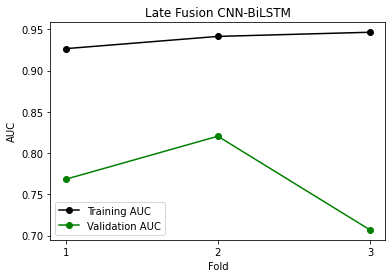

In [80]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Late Fusion CNN-BiLSTM")

#### Training performance and variance

In [81]:
late_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_cnnlstm_train_results

{'Accuracy': 0.7547252774238586,
 'ROC/AUC': 0.9381168683369955,
 'Precision': 0.7772484620412191,
 'Recall': 0.7349499066670736,
 'F1-score': 0.7477556268374125}

In [82]:
late_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
late_cnnlstm_train_var

{'Accuracy': 0.0008268210072965113,
 'ROC/AUC': 7.128772296343616e-05,
 'Precision': 0.0005820008798459575,
 'Recall': 0.0007699097060233207,
 'F1-score': 0.0013753348898062096}

#### Validation performance and variance

In [83]:
late_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_cnnlstm_val_results

{'Accuracy': 0.5014518996079763,
 'ROC/AUC': 0.7651375730832418,
 'Precision': 0.5128656625747681,
 'Recall': 0.4745429952939351,
 'F1-score': 0.4886064827442169}

In [84]:
late_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
late_cnnlstm_val_var

{'Accuracy': 0.0035786662958729766,
 'ROC/AUC': 0.002154200211929296,
 'Precision': 0.004531357671413143,
 'Recall': 0.004787568243629261,
 'F1-score': 0.00747079334809501}

#### Performance and predictions on test set

In [85]:
cnnlstm_area_latefusion_model = load_model(model_path / 'late_area_cnnlstm.h5')
y_pred = cnnlstm_area_latefusion_model.predict([body_X_test, face_X_test])
_, acc, auc, precision, recall, f1 = cnnlstm_area_latefusion_model.evaluate([body_X_test, face_X_test], y_test)
cnnlstm_auc.append(round(auc, 2))
cnnlstm_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 3s 100ms/step - loss: 1.6715 - accuracy: 0.3593 - auc_19: 0.6708 - precision_19: 0.3545 - recall_19: 0.2900 - f1_score: 0.2441
Accuracy: 35.93% 
ROC/AUC: 0.67 
Precision: 0.35 
Recall: 0.29 
F1 score: 0.24


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

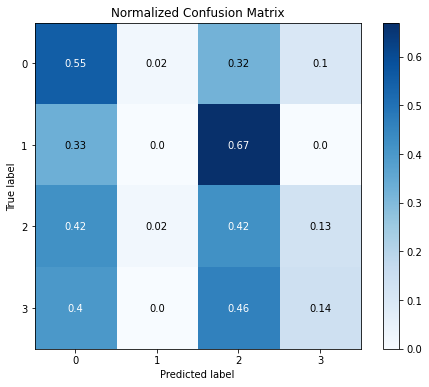

In [86]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

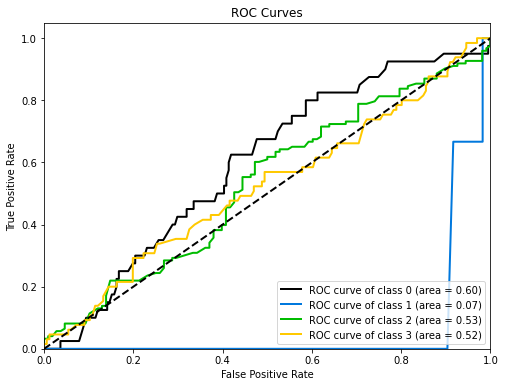

In [87]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

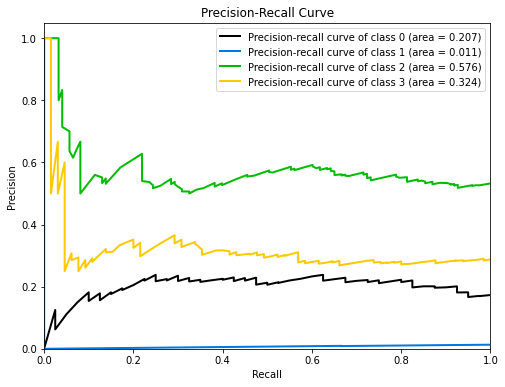

In [88]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, figsize=(8,6), plot_micro=False)

### 4.2 RCNN (Concatenation)

Epoch 1/100
14/14 - 2s - loss: 3.7067 - accuracy: 0.2542 - auc_21: 0.5197 - precision_21: 0.2832 - recall_21: 0.1876 - f1_score: 0.2134 - val_loss: 2.0065 - val_accuracy: 0.3270 - val_auc_21: 0.5584 - val_precision_21: 0.3268 - val_recall_21: 0.3175 - val_f1_score: 0.2027 - 2s/epoch - 173ms/step
Epoch 2/100
14/14 - 0s - loss: 2.4265 - accuracy: 0.3088 - auc_21: 0.5871 - precision_21: 0.3345 - recall_21: 0.2328 - f1_score: 0.2449 - val_loss: 5.7135 - val_accuracy: 0.3033 - val_auc_21: 0.4668 - val_precision_21: 0.3033 - val_recall_21: 0.3033 - val_f1_score: 0.1444 - 413ms/epoch - 30ms/step
Epoch 3/100
14/14 - 0s - loss: 3.0340 - accuracy: 0.3278 - auc_21: 0.5871 - precision_21: 0.3491 - recall_21: 0.2280 - f1_score: 0.2551 - val_loss: 1.9915 - val_accuracy: 0.1185 - val_auc_21: 0.4292 - val_precision_21: 0.1319 - val_recall_21: 0.1137 - val_f1_score: 0.1072 - 429ms/epoch - 31ms/step
Epoch 4/100
14/14 - 0s - loss: 2.4537 - accuracy: 0.3040 - auc_21: 0.5984 - precision_21: 0.3071 - recall

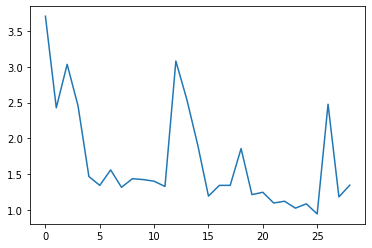

Epoch 1/100
14/14 - 2s - loss: 4.3467 - accuracy: 0.2185 - auc_22: 0.5050 - precision_22: 0.2463 - recall_22: 0.1568 - f1_score: 0.1897 - val_loss: 2.1370 - val_accuracy: 0.2701 - val_auc_22: 0.4812 - val_precision_22: 0.2755 - val_recall_22: 0.2559 - val_f1_score: 0.1167 - 2s/epoch - 171ms/step
Epoch 2/100
14/14 - 0s - loss: 3.5991 - accuracy: 0.2470 - auc_22: 0.5585 - precision_22: 0.2376 - recall_22: 0.1710 - f1_score: 0.2195 - val_loss: 2.6102 - val_accuracy: 0.0664 - val_auc_22: 0.3363 - val_precision_22: 0.0718 - val_recall_22: 0.0664 - val_f1_score: 0.0773 - 405ms/epoch - 29ms/step
Epoch 3/100
14/14 - 0s - loss: 3.3912 - accuracy: 0.2565 - auc_22: 0.5226 - precision_22: 0.2560 - recall_22: 0.1520 - f1_score: 0.2322 - val_loss: 2.4248 - val_accuracy: 0.2749 - val_auc_22: 0.4574 - val_precision_22: 0.3500 - val_recall_22: 0.1659 - val_f1_score: 0.1736 - 399ms/epoch - 28ms/step
Epoch 4/100
14/14 - 0s - loss: 2.9562 - accuracy: 0.3112 - auc_22: 0.5775 - precision_22: 0.3253 - recall

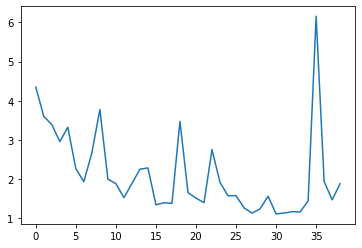

Epoch 1/100
14/14 - 2s - loss: 4.6207 - accuracy: 0.2109 - auc_23: 0.5065 - precision_23: 0.2105 - recall_23: 0.1611 - f1_score: 0.1732 - val_loss: 1.8036 - val_accuracy: 0.3476 - val_auc_23: 0.5749 - val_precision_23: 0.3462 - val_recall_23: 0.3000 - val_f1_score: 0.1869 - 2s/epoch - 170ms/step
Epoch 2/100
14/14 - 0s - loss: 3.0253 - accuracy: 0.3128 - auc_23: 0.5685 - precision_23: 0.3235 - recall_23: 0.1825 - f1_score: 0.2882 - val_loss: 1.2027 - val_accuracy: 0.4810 - val_auc_23: 0.7339 - val_precision_23: 0.4950 - val_recall_23: 0.2381 - val_f1_score: 0.2758 - 439ms/epoch - 31ms/step
Epoch 3/100
14/14 - 0s - loss: 3.9791 - accuracy: 0.3318 - auc_23: 0.5962 - precision_23: 0.3291 - recall_23: 0.2464 - f1_score: 0.2981 - val_loss: 2.2169 - val_accuracy: 0.3619 - val_auc_23: 0.5300 - val_precision_23: 0.3672 - val_recall_23: 0.3095 - val_f1_score: 0.1836 - 384ms/epoch - 27ms/step
Epoch 4/100
14/14 - 0s - loss: 2.5540 - accuracy: 0.3697 - auc_23: 0.6539 - precision_23: 0.4000 - recall

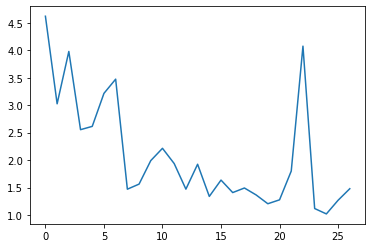

In [89]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(full_body_X):
    body_X_train, body_X_val = full_body_X[train_index], full_body_X[val_index]
    face_X_train, face_X_val = full_face_X[train_index], full_face_X[val_index]
    y_train, y_val = full_y[train_index], full_y[val_index]
    rcnn_area_latefusion_model = RCNN_fusioned(body_features, face_features, n_length, n_outputs, multiclass=True)
    history = rcnn_area_latefusion_model.train(body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_area_latefusion_model.save(model_path / 'late_area_rcnn.h5')

#### Training and Validation Line Plot

Text(0.5, 1.0, 'Late Fusion RCNN')

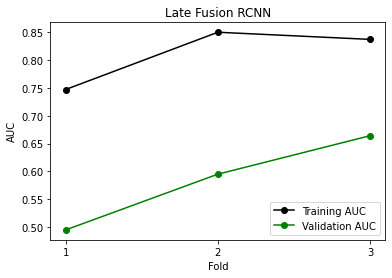

In [90]:
plt.plot(auc, label="Training AUC", marker="o", color="black")
plt.plot(auc_val, label="Validation AUC", marker="o", color="green")
plt.xticks(ticks=[0,1,2], labels=[1,2,3])
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.title("Late Fusion RCNN")

#### Training performance and variance

In [91]:
late_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_rcnn_train_results

{'Accuracy': 0.5814599196116129,
 'ROC/AUC': 0.8114827473958334,
 'Precision': 0.6079856157302856,
 'Recall': 0.5434776941935221,
 'F1-score': 0.538166880607605}

In [92]:
late_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
late_rcnn_train_var

{'Accuracy': 0.002677652706126644,
 'ROC/AUC': 0.002093982218227887,
 'Precision': 0.003199614490415096,
 'Recall': 0.002715509519336794,
 'F1-score': 0.00215100197202626}

#### Validation performance and variance

In [93]:
late_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_rcnn_val_results

{'Accuracy': 0.3640788396199544,
 'ROC/AUC': 0.58478115995725,
 'Precision': 0.36635322868824005,
 'Recall': 0.32605882982412976,
 'F1-score': 0.2706871032714844}

In [94]:
late_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
late_rcnn_val_var

{'Accuracy': 0.008382508875313456,
 'ROC/AUC': 0.0048247680283935385,
 'Precision': 0.008139186798918008,
 'Recall': 0.0047326055262381225,
 'F1-score': 0.004024149328783366}

#### Predictions and performance on test set

In [95]:
rcnn_area_latefusion_model = load_model(model_path / 'late_area_rcnn.h5')
y_pred = rcnn_area_latefusion_model.predict([body_X_test, face_X_test])
_, acc, auc, precision, recall, f1 = rcnn_area_latefusion_model.evaluate([body_X_test, face_X_test], y_test)
rcnn_auc.append(round(auc, 2))
rcnn_acc.append(round(acc * 100, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 0s 9ms/step - loss: 1.1527 - accuracy: 0.5065 - auc_23: 0.7539 - precision_23: 0.5529 - recall_23: 0.2035 - f1_score: 0.1920
Accuracy: 50.65% 
ROC/AUC: 0.75 
Precision: 0.55 
Recall: 0.20 
F1 score: 0.19


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

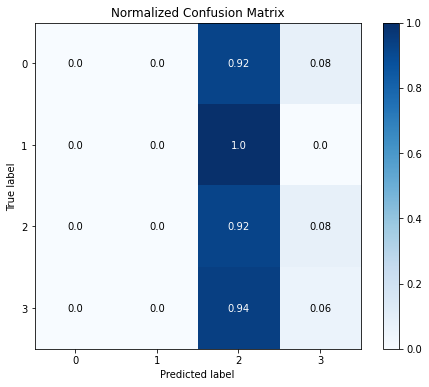

In [96]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

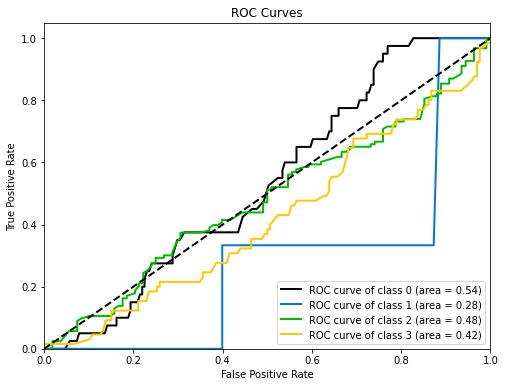

In [97]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

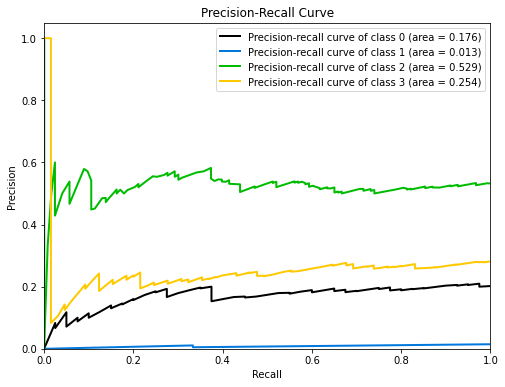

In [98]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, figsize=(8,6), plot_micro=False)

### 4.3 Ensemble

In [99]:
cnnlstm_body_member = KerasMember(name="CNN + Bidirectional LSTM Body Model", keras_model=cnnlstm_area_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
rcnn_body_member = KerasMember(name="RCNN Body Model", keras_model=rcnn_area_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
cnnlstm_face_member = KerasMember(name="CNN + Bidirectional LSTM Face Model", keras_model=cnnlstm_area_face_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, face_y_test))
rcnn_face_member = KerasMember(name="RCNN Face Model", keras_model=rcnn_area_face_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, face_y_test))

In [100]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(cnnlstm_body_member)
dirichletEnsemble.add_member(rcnn_body_member)
dirichletEnsemble.add_member(cnnlstm_face_member)
dirichletEnsemble.add_member(rcnn_face_member)
dirichletEnsemble.fit()

In [101]:
e = dirichletEnsemble.describe()

CNN + Bidirectional LSTM Body Model (weight: 0.0928)
RCNN Body Model (weight: 0.0073)
CNN + Bidirectional LSTM Face Model (weight: 0.8981)
RCNN Face Model (weight: 0.0019)
Accuracy: 39.39% - ROC/AUC: 0.54 - Precision: 0.31 - Recall: 0.30 - F1 score: 0.26


## Results

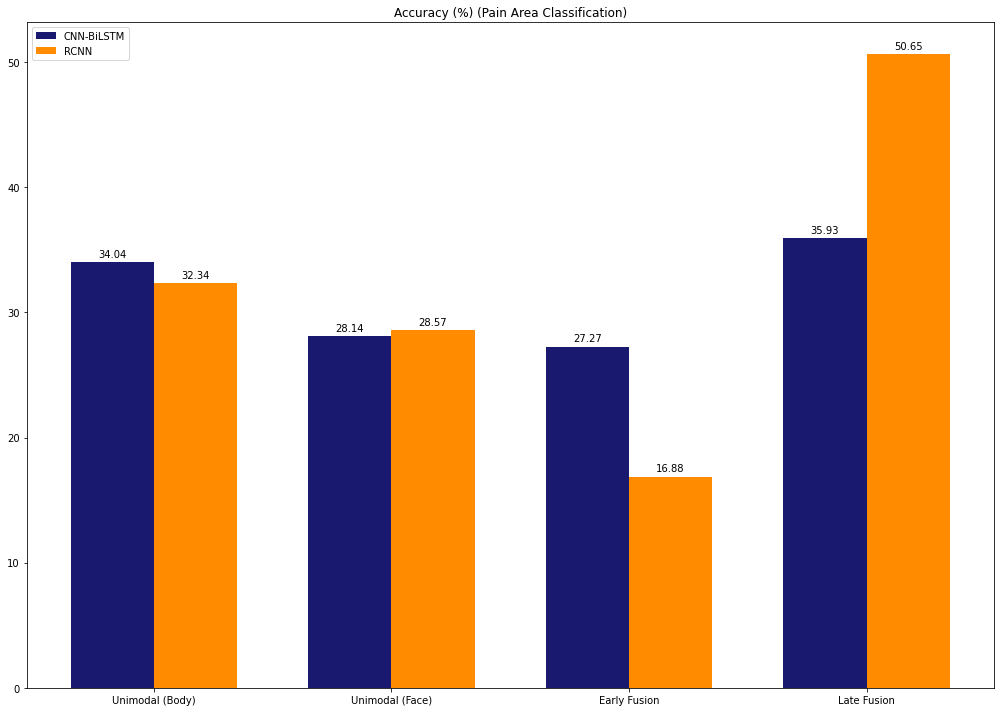

In [102]:
labels = ['Unimodal (Body)', 'Unimodal (Face)', 'Early Fusion', 'Late Fusion']

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(14, 10))
rects1 = ax.bar(x - width/2, cnnlstm_acc, width, label='CNN-BiLSTM', color='midnightblue')
rects2 = ax.bar(x + width/2, rcnn_acc, width, label='RCNN', color='darkorange')

ax.set_title('Accuracy (%) (Pain Area Classification)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

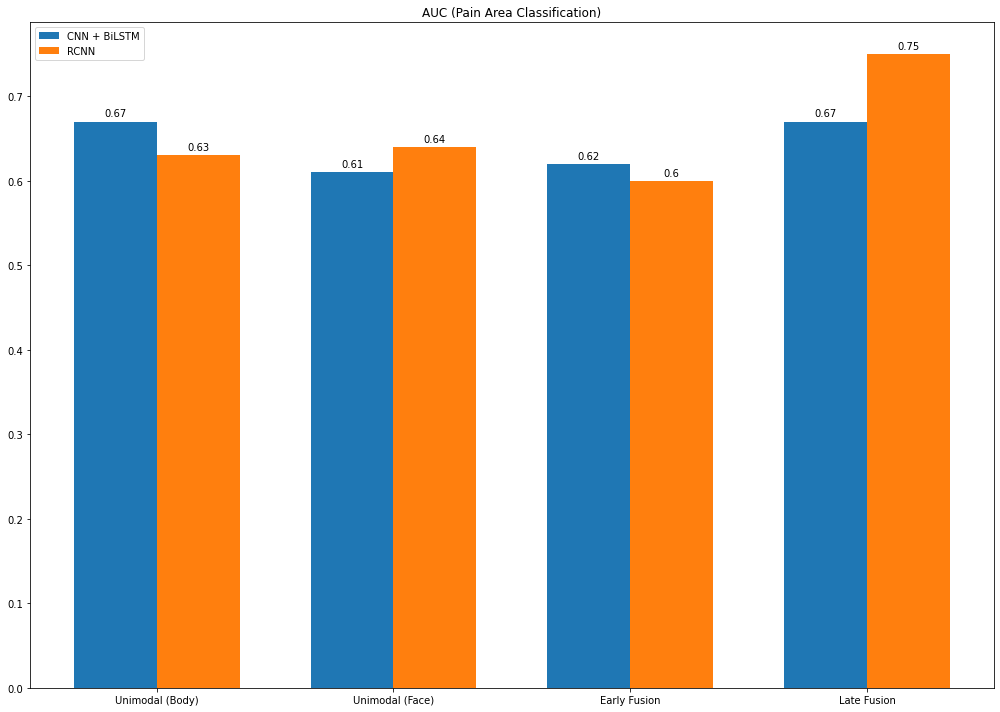

In [103]:
labels = ['Unimodal (Body)', 'Unimodal (Face)', 'Early Fusion', 'Late Fusion']

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(14, 10))
rects1 = ax.bar(x - width/2, cnnlstm_auc, width, label='CNN + BiLSTM')
rects2 = ax.bar(x + width/2, rcnn_auc, width, label='RCNN')

ax.set_title('AUC (Pain Area Classification)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()